# Canada Aviation Seasonality Analysis

1. Load **Global Vs. Canada annual Passengers** data (2012-2018).

aggregated from- 
https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2310025301
https://www.iata.org/en
https://www2023.icao.int

2. Load **Canada mothly Passengers** data (2012-2018).

from Statistics Canada

3. Compare annual passengers movement Canada VS Global data.
4. Compute monthly seasonality profiles.


In [2]:
#imports
import pandas as pd
import csv
import datetime as dt
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [7]:
# Load data 
CMonPas = pd.read_csv('Canada monthly passengers.csv')
Global = pd.read_csv('Global Vs. Canada (annual).csv')
NLA_activity = pd.read_csv('Clean_Activity_Data.csv')


## Canada Vs. Global total passengers movements comparison annually

In [135]:
# Create a stylish transposed table of Global data
# Clean the data: remove empty rows and unnamed columns
Global_clean = Global.dropna(how='all')  # Remove completely empty rows
Global_clean = Global_clean.loc[:, ~Global_clean.columns.str.contains('^Unnamed')]  # Remove unnamed columns

# Transpose the Global DataFrame
Global_transposed = Global_clean.set_index('Year').T

# Remove the index name (no "Metric" row)
Global_transposed.index.name = None

# Style the transposed table
styled_table = Global_transposed.style\
    .set_table_styles([
        {'selector': 'thead', 'props': [('background-color', '#003d82'), 
                                        ('color', 'white'),
                                        ('font-weight', 'bold'),
                                        ('text-align', 'center'),
                                        ('font-size', '14px')]},
        {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f0f0f0')]},
        {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', 'white')]},
        {'selector': 'td', 'props': [('text-align', 'center'),
                                    ('padding', '10px'),
                                    ('font-size', '13px')]},
        {'selector': 'th', 'props': [('padding', '12px'),
                                    ('font-size', '13px')]},
        {'selector': 'tbody tr:hover', 'props': [('background-color', '#e6f2ff')]},
        {'selector': 'tbody th', 'props': [('font-weight', 'bold'),
                                          ('text-align', 'left')]},
        {'selector': 'td:first-child', 'props': [('font-weight', 'bold')]}
    ])\
    .set_properties(**{'border': '1px solid #ddd'})\
    .format(precision=1, na_rep='—')

# Display the styled table
display(styled_table)


Year,2012,2013,2014,2015,2016,2017,2018
Canada Passengers (in millions),119,124,130,133,141,151,161
Yearly Growth %– Canada,—,4.2%,4.8%,2.3%,6.0%,7.1%,6.6%
Global Passengers (in millions),2977,3129,3300,3500,3800,4100,4300
Yearly Growth % – Global,—,5.1%,5.5%,6.1%,8.6%,7.9%,4.9%


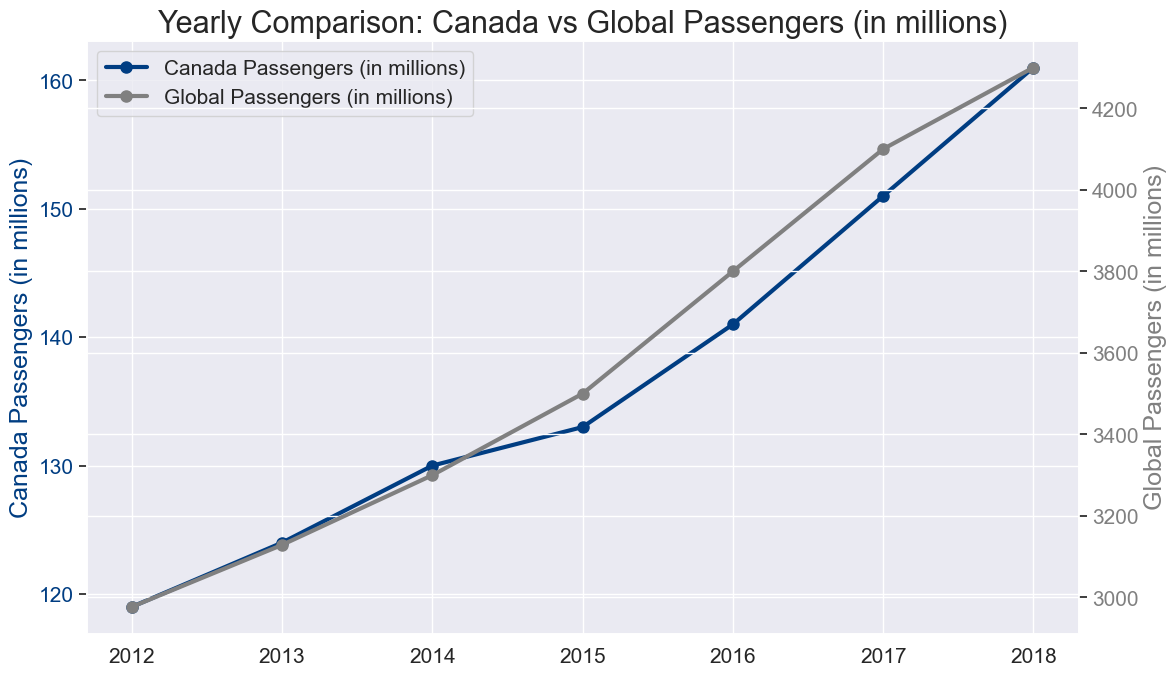

In [136]:
# Create the comparison plot
fig, ax1 = plt.subplots(figsize=(12,7))

color_canada = '#003d82'
color_global = '#808080'

label_fontsize = 18
tick_fontsize = 15
title_fontsize = 22
legend_fontsize = 15
line_width = 3

# Canada passengers on primary y-axis
ax1.plot(
    global_df["Year"],
    global_df["Canada Passengers (in millions)"],
    marker='o',
    label='Canada Passengers (in millions)',
    color=color_canada,
    linewidth=line_width,
    markersize=8
)

ax1.set_ylabel('Canada Passengers (in millions)', color=color_canada, fontsize=label_fontsize)
ax1.tick_params(axis='y', labelcolor=color_canada, labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)

# Global passengers on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(
    global_df["Year"],
    global_df["Global Passengers (in millions)"],
    marker='o',
    label='Global Passengers (in millions)',
    color=color_global,
    linewidth=line_width,
    markersize=8
)
ax2.set_ylabel('Global Passengers (in millions)', color=color_global, fontsize=label_fontsize)
ax2.tick_params(axis='y', labelcolor=color_global, labelsize=tick_fontsize)

plt.title('Yearly Comparison: Canada vs Global Passengers (in millions)', fontsize=title_fontsize)
fig.tight_layout()

# Set up a custom legend that includes both lines
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
leg = ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=legend_fontsize)
for text in leg.get_texts():
    text.set_fontsize(legend_fontsize)

plt.grid(True, which='both', axis='x', linestyle='--', linewidth=1)
plt.show()



## Canada sesonality trends

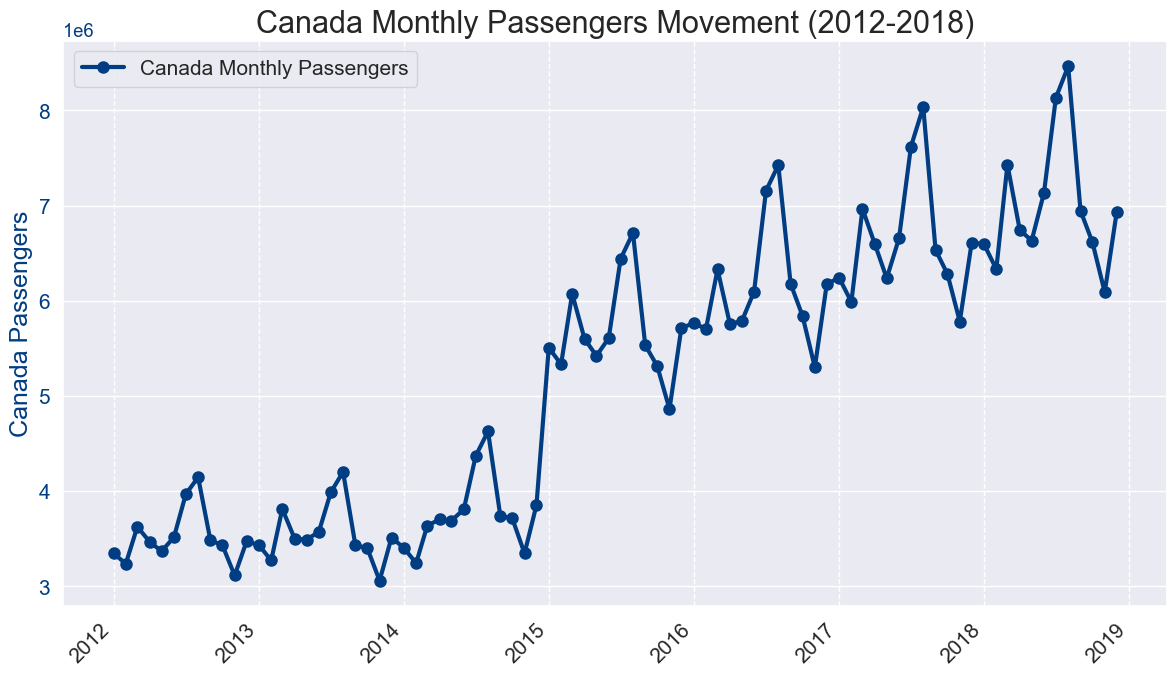

In [137]:
# Prepare monthly data for plotting
monthly_df = CMonPas.copy()

# Create a mapping for Hebrew month abbreviations to month numbers
hebrew_months = {
    'ינו': 1,   # January
    'פבר': 2,   # February
    'מרץ': 3,   # March
    'אפר': 4,   # April
    'מאי': 5,   # May
    'יונ': 6,   # June
    'יול': 7,   # July
    'אוג': 8,   # August
    'ספט': 9,   # September
    'אוק': 10,  # October
    'נוב': 11,  # November
    'דצמ': 12   # December
}

# Parse month column and create date column
def parse_hebrew_month(month_str):
    # Extract month abbreviation and year (last 2 digits)
    month_heb = month_str.split('-')[0]
    year_2digit = int(month_str.split('-')[1])
    # Convert 2-digit year to 4-digit (12-18 -> 2012-2018)
    year = 2000 + year_2digit
    month_num = hebrew_months.get(month_heb, 1)
    return dt.datetime(year, month_num, 1)

# Create date column
monthly_df['Date'] = monthly_df['month'].apply(parse_hebrew_month)

# Clean and convert passengers column (remove commas and convert to numeric)
monthly_df['Passengers'] = monthly_df['Passengers'].str.replace(',', '').astype(float)

# Create the graph using the same style as the previous graph
fig, ax = plt.subplots(figsize=(12, 7))

color_canada = '#003d82'
label_fontsize = 18
tick_fontsize = 15
title_fontsize = 22
legend_fontsize = 15
line_width = 3

# Plot monthly passengers
ax.plot(
    monthly_df['Date'],
    monthly_df['Passengers'],
    marker='o',
    label='Canada Monthly Passengers',
    color=color_canada,
    linewidth=line_width,
    markersize=8
)

ax.set_ylabel('Canada Passengers', color=color_canada, fontsize=label_fontsize)
ax.tick_params(axis='y', labelcolor=color_canada, labelsize=tick_fontsize)
ax.tick_params(axis='x', labelsize=tick_fontsize)

# Format x-axis to show dates nicely
fig.autofmt_xdate(rotation=45)

plt.title('Canada Monthly Passengers Movement (2012-2018)', fontsize=title_fontsize)
fig.tight_layout()

# Add legend
leg = ax.legend(loc='upper left', fontsize=legend_fontsize)
for text in leg.get_texts():
    text.set_fontsize(legend_fontsize)

plt.grid(True, which='both', axis='x', linestyle='--', linewidth=1)
plt.show()


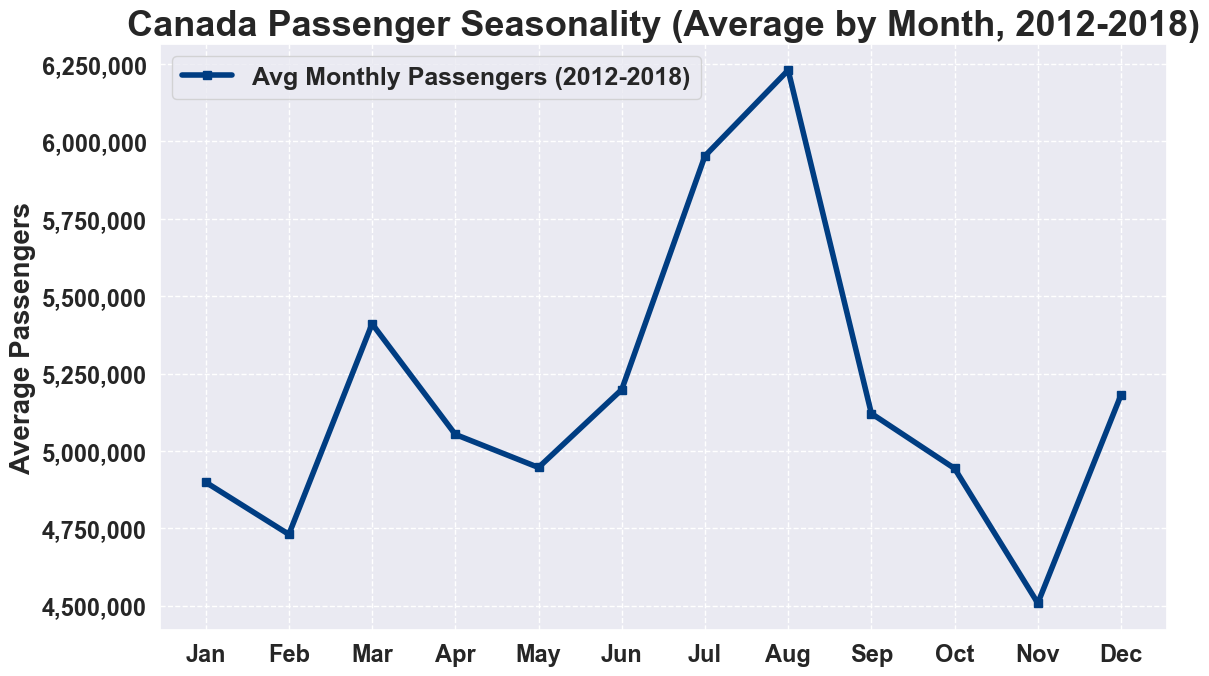

In [138]:
# Aggregate seasonality by month of year (ignoring year, summing/averaging passengers per month)
import calendar

# Extract month number from dates
monthly_df['Month_Num'] = monthly_df['Date'].dt.month

# Group by month number, calculate mean passengers
seasonal_df = monthly_df.groupby('Month_Num')['Passengers'].mean().reset_index()

# For proper month order and names
seasonal_df['Month_Name'] = seasonal_df['Month_Num'].apply(lambda x: calendar.month_abbr[x])

# Sort by month number just in case
seasonal_df = seasonal_df.sort_values('Month_Num')

# Round average passengers so no decimal, and convert to int for display
seasonal_df['Passengers_Int'] = seasonal_df['Passengers'].round().astype(int)

# Use the same Canada blue as before
color_canada = '#003d82'

# Plot seasonality (average monthly passengers by month in the year)
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(
    seasonal_df['Month_Name'],
    seasonal_df['Passengers_Int'],  # Use integer (rounded) for plotting
    marker='s',
    color=color_canada,
    linewidth=4,  # Thicker line
    label='Avg Monthly Passengers (2012-2018)'
)

# Remove x-axis label
ax.set_xlabel('')

# Make y-axis label and title larger and bold
ax.set_ylabel('Average Passengers', fontsize=20, fontweight='bold')
ax.set_title('Canada Passenger Seasonality (Average by Month, 2012-2018)', fontsize=26, fontweight='bold')

# Make tick labels larger and bold
ax.tick_params(axis='both', labelsize=17)
ax.set_xticklabels(seasonal_df['Month_Name'], fontsize=17, fontweight='bold')
ax.set_yticklabels([f"{int(y):,}" for y in ax.get_yticks()], fontsize=17, fontweight='bold')

# Make legend text larger and bold
legend = ax.legend(fontsize=18)
for text in legend.get_texts():
    text.set_fontweight('bold')

plt.grid(True, linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()


In [148]:
# Create seasonality table with 2017, 2018, average, and month-to-month percentage changes
import calendar

# Filter data for 2017 and 2018
monthly_df_2017_2018 = monthly_df[monthly_df['Date'].dt.year.isin([2017, 2018])].copy()

# Create pivot table with months as rows and years as columns
pivot_table = monthly_df_2017_2018.pivot_table(
    index='Month_Num',
    columns=monthly_df_2017_2018['Date'].dt.year,
    values='Passengers',
    aggfunc='sum'
).sort_index()

# Calculate average across all years (2012-2018) for each month
monthly_avg = monthly_df.groupby('Month_Num')['Passengers'].mean().sort_index()

# Calculate month-to-month percentage changes for 2017
pct_change_2017 = []
for i in range(12):
    if i == 0:
        pct_change_2017.append(None)  # No previous month for January
    else:
        prev_val = pivot_table[2017].values[i-1]
        curr_val = pivot_table[2017].values[i]
        pct_change = ((curr_val - prev_val) / prev_val) * 100
        pct_change_2017.append(pct_change)

# Calculate month-to-month percentage changes for 2018
pct_change_2018 = []
for i in range(12):
    if i == 0:
        pct_change_2018.append(None)  # No previous month for January
    else:
        prev_val = pivot_table[2018].values[i-1]
        curr_val = pivot_table[2018].values[i]
        pct_change = ((curr_val - prev_val) / prev_val) * 100
        pct_change_2018.append(pct_change)

# Calculate month-to-month percentage changes for Average (across all years 2012-2018)
pct_change_avg = []
avg_values = monthly_avg.values
for i in range(12):
    if i == 0:
        pct_change_avg.append(None)  # No previous month for January
    else:
        prev_val = avg_values[i-1]
        curr_val = avg_values[i]
        pct_change = ((curr_val - prev_val) / prev_val) * 100
        pct_change_avg.append(pct_change)

# Create the main table with % change columns next to their year column, use requested label for average % column
seasonality_table = pd.DataFrame({
    'Month': [calendar.month_abbr[i] for i in range(1, 13)],
    '2017': pivot_table[2017].values,
    '2017 Monthly % Change': pct_change_2017,
    '2018': pivot_table[2018].values,
    '2018 Monthly % Change': pct_change_2018,
    'Average': avg_values,
    'Áverage 2012-2018 % Change': pct_change_avg   # <--- updated label
})

# Format the table for display
seasonality_table_display = seasonality_table.copy()
seasonality_table_display['2017'] = seasonality_table_display['2017'].apply(lambda x: f"{x:,.0f}")
seasonality_table_display['2018'] = seasonality_table_display['2018'].apply(lambda x: f"{x:,.0f}")
seasonality_table_display['Average'] = seasonality_table_display['Average'].apply(lambda x: f"{x:,.0f}")
seasonality_table_display['2017 Monthly % Change'] = seasonality_table_display['2017 Monthly % Change'].apply(
    lambda x: f"{x:.2f}%" if pd.notna(x) else "—"
)
seasonality_table_display['2018 Monthly % Change'] = seasonality_table_display['2018 Monthly % Change'].apply(
    lambda x: f"{x:.2f}%" if pd.notna(x) else "—"
)
seasonality_table_display['Áverage 2012-2018 % Change'] = seasonality_table_display['Áverage 2012-2018 % Change'].apply(
    lambda x: f"{x:.2f}%" if pd.notna(x) else "—"
)

# Style the table
styled_seasonality = seasonality_table_display.style\
    .set_table_styles([
        {'selector': 'thead', 'props': [('background-color', '#003d82'), 
                                        ('color', 'white'),
                                        ('font-weight', 'bold'),
                                        ('text-align', 'center'),
                                        ('font-size', '14px')]},
        {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f0f0f0')]},
        {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', 'white')]},
        {'selector': 'td', 'props': [('text-align', 'center'),
                                    ('padding', '10px'),
                                    ('font-size', '13px')]},
        {'selector': 'th', 'props': [('padding', '12px'),
                                    ('font-size', '13px')]},
        {'selector': 'tbody tr:hover', 'props': [('background-color', '#e6f2ff')]},
        {'selector': 'tbody th', 'props': [('font-weight', 'bold'),
                                          ('text-align', 'left')]},
        {'selector': 'td:first-child', 'props': [('font-weight', 'bold')]}
    ])\
    .set_properties(**{'border': '1px solid #ddd'})

# Display the styled table
display(styled_seasonality)



,Month,2017,2017 Monthly % Change,2018,2018 Monthly % Change,Average,Áverage 2012-2018 % Change
0,Jan,"6,243,000",—,"6,594,000",—,"4,899,000",—
1,Feb,"5,987,000",-4.10%,"6,332,000",-3.97%,"4,730,429",-3.44%
2,Mar,"6,965,000",16.34%,"7,430,000",17.34%,"5,410,857",14.38%
3,Apr,"6,597,000",-5.28%,"6,744,000",-9.23%,"5,053,429",-6.61%
4,May,"6,236,000",-5.47%,"6,631,000",-1.68%,"4,946,571",-2.11%
5,Jun,"6,656,000",6.74%,"7,133,000",7.57%,"5,198,286",5.09%
6,Jul,"7,619,000",14.47%,"8,133,000",14.02%,"5,953,286",14.52%
7,Aug,"8,035,000",5.46%,"8,463,000",4.06%,"6,230,429",4.66%
8,Sep,"6,534,000",-18.68%,"6,946,000",-17.93%,"5,121,000",-17.81%
9,Oct,"6,280,000",-3.89%,"6,615,000",-4.77%,"4,943,286",-3.47%


In [149]:
# Export the seasonality_table to CSV with the specified name
seasonality_table.to_csv("Canada Seasonality data.csv", index=False)


# NLA passengers 2017-2018 comparison


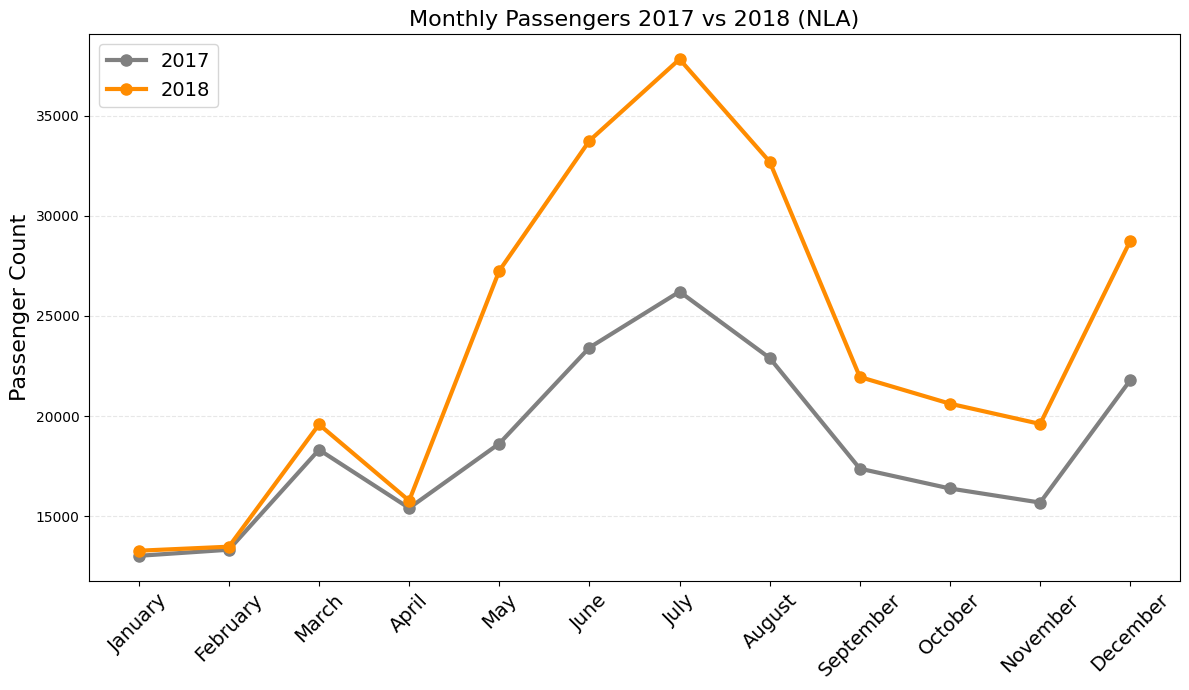

In [28]:
## NLA_PASS table - sum of total flights each month between Jan 2017 and Dec. 2018, using 'Year' and 'Month' columns

# Filter for years 2017 and 2018
NLA_activity_filtered = NLA_activity[(NLA_activity['Year'] >= 2017) & (NLA_activity['Year'] <= 2018)].copy()

# Create Month_Label as YYYY-MM from Year and Month columns
NLA_activity_filtered['Month_Label'] = (
    NLA_activity_filtered['Year'].astype(str) + '-' + 
    NLA_activity_filtered['Month'].astype(str).str.zfill(2)
)

# Create months_range for Jan 2017 to Dec 2018
months_range = pd.period_range('2017-01', '2018-12', freq='M').strftime('%Y-%m')

# Group by Year, Month, Month_Label and sum 'Total Flights'
NLA_Pass = (
    NLA_activity_filtered
    .groupby(['Year', 'Month', 'Month_Label'], as_index=False)['Total Flights']
    .sum()
    .set_index(['Year', 'Month', 'Month_Label'])
    .reindex(
        pd.MultiIndex.from_arrays([
            [int(s[:4]) for s in months_range],
            [int(s[5:7]) for s in months_range],
            months_range
        ], names=['Year', 'Month', 'Month_Label']),
        fill_value=0
    )
    .reset_index()
    .rename(columns={'Total Flights': "NLA_Pass"})
)

NLA_Pass

### Plot comparison 

# Prepare the data
monthly_counts = NLA_Pass.pivot(index='Month', columns='Year', values='NLA_Pass')
months_labels = NLA_Pass[NLA_Pass['Year'] == 2017]['Month_Label']

# Generate list of month names for x-axis
month_names = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

xticks_labels = month_names

#Plot 2017
plt.figure(figsize=(12, 7))
plt.plot(months_labels, monthly_counts[2017], color='grey', label='2017',
         linewidth=3, marker='o', markersize=8)
# Plot 2018
plt.plot(months_labels, monthly_counts[2018], color='darkorange', label='2018',
         linewidth=3, marker='o', markersize=8)

plt.title('Monthly Passengers 2017 vs 2018 (NLA)', fontsize=16)
plt.ylabel('Passenger Count', fontsize=16)
plt.xticks(ticks=range(len(months_labels)), labels=xticks_labels, rotation=45, fontsize=14)
plt.legend(fontsize=14, loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()




### **Conclusion 1:** We can see a good growth from 2017 to 2018 passengers flying with us after the promotion






# NLA growth to market comparison

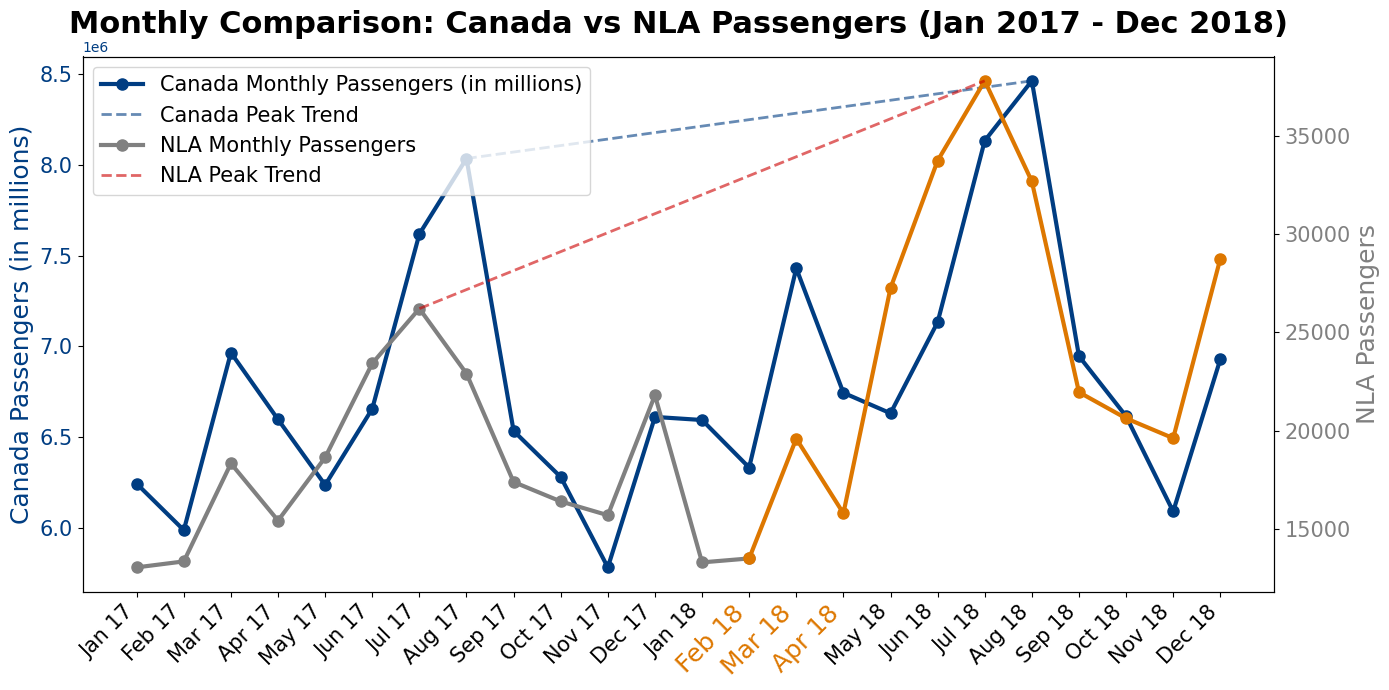

In [43]:
# Compare Canada Monthly Passengers vs NLA Monthly Passengers (Jan 2017 - Dec 2018)

# Prepare Canada monthly data from CMonPas for 2017-2018
# Create a mapping for Hebrew month abbreviations to month numbers
hebrew_months = {
    'ינו': 1,   # January
    'פבר': 2,   # February
    'מרץ': 3,   # March
    'אפר': 4,   # April
    'מאי': 5,   # May
    'יונ': 6,   # June
    'יול': 7,   # July
    'אוג': 8,   # August
    'ספט': 9,   # September
    'אוק': 10,  # October
    'נוב': 11,  # November
    'דצמ': 12   # December
}

# Parse month column and create date column
def parse_hebrew_month(month_str):
    # Extract month abbreviation and year (last 2 digits)
    month_heb = month_str.split('-')[0]
    year_2digit = int(month_str.split('-')[1])
    # Convert 2-digit year to 4-digit (12-18 -> 2012-2018)
    year = 2000 + year_2digit
    month_num = hebrew_months.get(month_heb, 1)
    return dt.datetime(year, month_num, 1)

# Process CMonPas data
canada_monthly = CMonPas.copy()
canada_monthly['Date'] = canada_monthly['month'].apply(parse_hebrew_month)
canada_monthly['Passengers'] = canada_monthly['Passengers'].str.replace(',', '').astype(float)

# Filter for 2017-2018
canada_monthly_2017_2018 = canada_monthly[
    (canada_monthly['Date'].dt.year >= 2017) & 
    (canada_monthly['Date'].dt.year <= 2018)
].copy().sort_values('Date')

# Create Month_Label for Canada data to match NLA format
canada_monthly_2017_2018['Month_Label'] = (
    canada_monthly_2017_2018['Date'].dt.year.astype(str) + '-' + 
    canada_monthly_2017_2018['Date'].dt.month.astype(str).str.zfill(2)
)

# Prepare NLA data - ensure it's sorted by Year and Month
NLA_Pass_sorted = NLA_Pass.sort_values(['Year', 'Month']).copy()

# Create the comparison plot with dual y-axis
fig, ax1 = plt.subplots(figsize=(14, 7))

color_canada = '#003d82'
color_nla = '#808080'  # Grey for NLA line
color_nla_orange = '#DD7700'  # Lighter orange for line and labels

label_fontsize = 18
tick_fontsize = 15
title_fontsize = 22
legend_fontsize = 15
line_width = 3

# Canada passengers on primary y-axis
ax1.plot(
    canada_monthly_2017_2018['Month_Label'],
    canada_monthly_2017_2018['Passengers'],
    marker='o',
    label='Canada Monthly Passengers (in millions)',
    color=color_canada,
    linewidth=line_width,
    markersize=8
)

ax1.set_ylabel('Canada Passengers (in millions)', color=color_canada, fontsize=label_fontsize)
ax1.tick_params(axis='y', labelcolor=color_canada, labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)

# NLA passengers on secondary y-axis - split into two segments
ax2 = ax1.twinx()

# Split NLA data: grey until Feb 2018 (inclusive), orange from Feb 2018
nla_grey_segment = NLA_Pass_sorted[NLA_Pass_sorted['Month_Label'] <= '2018-02']
nla_orange_segment = NLA_Pass_sorted[NLA_Pass_sorted['Month_Label'] >= '2018-02']

# Plot grey segment (Jan 2017 - Feb 2018, inclusive) - connects Jan to Feb with grey
if len(nla_grey_segment) > 0:
    ax2.plot(
        nla_grey_segment['Month_Label'],
        nla_grey_segment['NLA_Pass'],
        marker='o',
        label='NLA Monthly Passengers',
        color=color_nla,
        linewidth=line_width,
        markersize=8
    )

# Plot orange segment (Feb 2018 - Dec 2018) - starts from Feb 2018
if len(nla_orange_segment) > 0:
    ax2.plot(
        nla_orange_segment['Month_Label'],
        nla_orange_segment['NLA_Pass'],
        marker='o',
        label='',  # Empty label to avoid duplicate in legend
        color=color_nla_orange,  # Orange color
        linewidth=line_width,
        markersize=8
    )

ax2.set_ylabel('NLA Passengers', color=color_nla, fontsize=label_fontsize)
ax2.tick_params(axis='y', labelcolor=color_nla, labelsize=tick_fontsize)

# Format x-axis labels - show abbreviated month names with 2-digit year (Jan 17, Feb 17, etc.)
import calendar
x_labels = []
for date in canada_monthly_2017_2018['Date']:
    month_abbr = calendar.month_abbr[date.month]
    year_2digit = str(date.year)[-2:]
    x_labels.append(f"{month_abbr} {year_2digit}")

ax1.set_xticks(range(len(canada_monthly_2017_2018)))
ax1.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=tick_fontsize)

# Set specific labels to orange with larger font size (Feb 18, Mar 18, Apr 18)
for i, date in enumerate(canada_monthly_2017_2018['Date']):
    if date.year == 2018 and date.month in [2, 3, 4]:  # Feb, Mar, Apr 2018
        ax1.get_xticklabels()[i].set_color(color_nla_orange)
        ax1.get_xticklabels()[i].set_fontsize(tick_fontsize + 3)  # Make labels larger

# Find peaks and draw connecting lines
# Canada peaks
canada_2017 = canada_monthly_2017_2018[canada_monthly_2017_2018['Date'].dt.year == 2017]
canada_2018 = canada_monthly_2017_2018[canada_monthly_2017_2018['Date'].dt.year == 2018]

canada_peak_2017_idx = canada_2017['Passengers'].idxmax()
canada_peak_2018_idx = canada_2018['Passengers'].idxmax()

# Get x positions (list indices)
canada_peak_2017_x = list(canada_monthly_2017_2018.index).index(canada_peak_2017_idx)
canada_peak_2018_x = list(canada_monthly_2017_2018.index).index(canada_peak_2018_idx)
canada_peak_2017_y = canada_monthly_2017_2018.loc[canada_peak_2017_idx, 'Passengers']
canada_peak_2018_y = canada_monthly_2017_2018.loc[canada_peak_2018_idx, 'Passengers']

# NLA peaks
nla_2017 = NLA_Pass_sorted[NLA_Pass_sorted['Year'] == 2017]
nla_2018 = NLA_Pass_sorted[NLA_Pass_sorted['Year'] == 2018]

nla_peak_2017_idx = nla_2017['NLA_Pass'].idxmax()
nla_peak_2018_idx = nla_2018['NLA_Pass'].idxmax()

# Find x positions for NLA peaks (match with Canada data by Month_Label)
nla_peak_2017_month_label = NLA_Pass_sorted.loc[nla_peak_2017_idx, 'Month_Label']
nla_peak_2018_month_label = NLA_Pass_sorted.loc[nla_peak_2018_idx, 'Month_Label']

nla_peak_2017_x = list(canada_monthly_2017_2018['Month_Label']).index(nla_peak_2017_month_label)
nla_peak_2018_x = list(canada_monthly_2017_2018['Month_Label']).index(nla_peak_2018_month_label)

nla_peak_2017_y = NLA_Pass_sorted.loc[nla_peak_2017_idx, 'NLA_Pass']
nla_peak_2018_y = NLA_Pass_sorted.loc[nla_peak_2018_idx, 'NLA_Pass']

# Draw connecting lines for peaks
ax1.plot([canada_peak_2017_x, canada_peak_2018_x], 
         [canada_peak_2017_y, canada_peak_2018_y],
         '--', color=color_canada, linewidth=2, alpha=0.6, label='Canada Peak Trend')

ax2.plot([nla_peak_2017_x, nla_peak_2018_x], 
         [nla_peak_2017_y, nla_peak_2018_y],
         '--', color='#CC0000', linewidth=2, alpha=0.6, label='NLA Peak Trend')  # Red for peak connecting line

plt.title('Monthly Comparison: Canada vs NLA Passengers (Jan 2017 - Dec 2018)', 
          fontsize=title_fontsize, fontweight='bold')
fig.tight_layout()

# Set up a custom legend that includes both lines
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
leg = ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=legend_fontsize)
for text in leg.get_texts():
    text.set_fontsize(legend_fontsize)

plt.grid(True, which='both', axis='x', linestyle='--', linewidth=1, alpha=0.3)
plt.show()


### **Conclusion 2:** NLA had much bigger growth in number of flights sold after the promotion, than the expected growth levels based on the market seaonality alone